In [1]:
!pip install pytorch-ignite -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 7.0 MB/s eta 0:00:00


In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers


In [3]:
DATA_DIR='./data' # データ保存用のディレクトリ
IMAGE_SIZE = 32 # 入力画像1辺のサイズ
NUM_CLASSES = 100 # 分類するクラスの数
NUM_WORKERS = 8 # データローダーが使用するサブプロセスの数を指定
BATCH_SIZE = 32 # ミニバッチのサイズ
EPOCHS = 150 # 学習回数
LEARNING_RATE = 1e-3 # 最大学習率
WEIGHT_DECAY = 1e-1 # オプティマイザーの重み減衰率


In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)


device: cuda


In [5]:
# トレーニングデータに適用する一連の変換操作をtransforms.Composeにまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右反転
    # 4ピクセルのパディングを挿入してランダムに切り抜く
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    # 画像のコントラスト、彩度、色相をランダムに変化させる
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor() # テンソルに変換
])


In [6]:
# CIFAR-100データセットのトレーニングデータを読み込み、データ拡張を適用
train_dset = datasets.CIFAR100(
    root=DATA_DIR, train=True, download=True, transform=train_transform)
# CIFAR-100データセットのテストデータを読み込んでテンソルに変換する処理のみを行う
test_dset = datasets.CIFAR100(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 169001437/169001437 [00:03<00:00, 43203496.93it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# トレーニング用のデータローダーを作成
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 抽出時にシャッフルする
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )

# テスト用のデータローダーを作成
test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    shuffle=False, # 抽出時にシャッフルしない
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )


In [8]:
class LayerNormChannels(nn.Module):
    """ チャンネル次元に対して正規化を適用する

    """
    def __init__(self, channels):
        """
        Args:
            channels (int): 特徴テンソルのチャンネル数
        """
        super().__init__()
        # チャンネル次元に基づいた正規化層を生成
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        """ フォワードパス

        Args:
            x (torch.Tensor): 特徴テンソル
                              形状: (bs, channels, height, width)
        Returns:
            torch.Tensor: チャンネル次元に沿った正規化が適用されたテンソル
                          形状は入力テンソルと同じ
        """
        # テンソルのチャンネル次元を最後に転置
        # (B, C, H, W) -> (B, H, W, C)
        x = x.transpose(1, -1)
        # チャンネル次元に正規化を適用
        x = self.norm(x)
        # 元のテンソル形状に戻すために再び転置
        # (B, H, W, C) -> (B, C, H, W)
        x = x.transpose(-1, 1)

        # 正規化されたテンソルを返す
        return x


In [9]:
class Residual(nn.Module):
    """ 残差接続を実装する

    """
    def __init__(self, *layers):
        """
        Args:
            *layers (nn.Module): 残差接続に使用される一連のレイヤー
        """
        super().__init__()
        # 渡されたレイヤーをSequentialオブジェクトにまとめる
        self.residual = nn.Sequential(*layers)
        # 残差接続のスケーリングパラメーターgammaを初期化（初期値は0）
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """ フォワードパス

        Args:
            x (torch.Tensor): 特徴テンソル
                形状: (batch_size, channels, height, width)
        Returns:
            torch.Tensor: 残差接続を適用した結果のテンソル
                          元の入力にスケールされた残差が加算される
        """
        # 入力xに対してgamma * residual(x)を加算し、その結果を返す
        return x + self.gamma * self.residual(x)


In [10]:
class ConvNeXtBlock(Residual):
    """ 残差接続を持つ複数の畳み込み層と正規化、活性化で構成されるブロック

    """
    def __init__(self, channels, kernel_size, mult=4, p_drop=0.):
        """
        Args:
            channels (int): 入力および出力のチャンネル数
            kernel_size (int): 畳み込み層のカーネルサイズ
            mult (int): 隠れ層のチャンネル数を決定するための倍率
            p_drop (float): ドロップアウト率
        """
        # 畳み込みにおけるパディングを計算（カーネルサイズによって動的に決定）
        padding = (kernel_size - 1) // 2
        # 隠れ層のチャンネル数を計算（入力チャンネル数 * mult）
        hidden_channels = channels * mult
        # スーパークラスResidualのコンストラクターにレイヤーを渡す
        super().__init__(
            # 深さ方向の畳み込み（Depthwise畳み込み）を行うレイヤー
            nn.Conv2d(
                channels, channels, kernel_size, padding=padding, groups=channels
            ),
            # チャンネルごとに正規化を行うレイヤー
            LayerNormChannels(channels),
            # 1x1の畳み込み（Pointwise畳み込み）を行うレイヤー
            nn.Conv2d(channels, hidden_channels, 1),
            nn.GELU(), # GELU活性化関数
            # 1x1の畳み込みによるチャンネル数の縮小を行うレイヤー
            nn.Conv2d(hidden_channels, channels, 1),
            nn.Dropout(p_drop) # ドロップアウト
        )


In [11]:
class DownsampleBlock(nn.Sequential):
    """ 画像の解像度を下げるためのダウンサンプリングブロック
        チャンネルごとの正規化ブロックとストライド付き畳み込みで構成される
    """
    def __init__(self, in_channels, out_channels, stride=2):
        """
        Args:
            in_channels (int): 入力テンソルのチャンネル数
            out_channels (int): 出力テンソルのチャンネル数
            stride (int): 畳み込み層で使用されるストライドの値
                          デフォルトの2は入力テンソルの解像度を半分にする
        """
        # スーパークラスのコンストラクターにブロックを構成するレイヤーを渡す
        super().__init__(
            # チャンネルごとの正規化を行うブロック
            LayerNormChannels(in_channels),
            # ストライド付きの畳み込み層でダウンサンプリングを行う
            nn.Conv2d(in_channels, out_channels, stride, stride=stride)
        )


In [12]:
class Stage(nn.Sequential):
    """ ConvNeXtモデル内の1つのステージを構築

    ステージには、必要に応じてダウンサンプリングブロックと
    複数のConvNeXtブロックが含まれる
    """
    def __init__(
            self,
            in_channels, out_channels,
            num_blocks,
            kernel_size,
            p_drop=0.
    ):
        """
        Args:
            in_channels (int): 入力テンソルのチャンネル数
            out_channels (int): 出力テンソルのチャンネル数
            num_blocks (int): ステージ内に含まれるConvNeXtBlockの数
            kernel_size (int): ConvNeXtBlockに使用するカーネルサイズ
            p_drop (float, optional): ドロップアウト率
        """
        # 入力チャンネルと出力チャンネルが異なる場合はダウンサンプリングブロックを配置
        if in_channels == out_channels:
            layers = []  # ダウンサンプリングが不要な場合は空のリスト
        else:
            # ダウンサンプリングブロックを配置
            layers = [DownsampleBlock(in_channels, out_channels)]

        # 指定された数のConvNeXtBlockを配置
        for _ in range(num_blocks):
            layers += [
                ConvNeXtBlock(out_channels, kernel_size, p_drop=p_drop)
            ]

        # スーパークラスのコンストラクターにレイヤーのリストを渡す
        super().__init__(*layers)


In [13]:
class ConvNeXtBody(nn.Sequential):
    """ 複数のステージ（Stage）を順番に組み合わせて
        特徴量の抽出と変換を行う
    """
    def __init__(
            self,
            in_channels,
            channel_list,
            num_blocks_list,
            kernel_size,
            p_drop=0.
    ):
        """
        Args:
            in_channels(int): 入力テンソルのチャンネル数
            channel_list (list of int): 各ステージの出力チャンネル数のリスト
            num_blocks_list(list of int): 各ステージに含まれるブロック数のリスト
            kernel_size(int): 畳み込み層のカーネルサイズ
            p_drop(float): ドロップアウト率
        """
        layers = [] # レイヤーリストを初期化
        # channel_listとnum_blocks_listをペアにして、各ステージを順次構築
        for out_channels, num_blocks in zip(channel_list, num_blocks_list):
            # ステージ（Stageクラス）を生成してリストに追加
            layers.append(
                Stage(
                    in_channels,
                    out_channels,
                    num_blocks,
                    kernel_size,
                    p_drop
                )
            )
            # 現在の出力チャンネル数を次のステージの入力チャンネル数として設定
            in_channels = out_channels

        # スーパークラスのコンストラクターにレイヤーのリストを渡す
        super().__init__(*layers)


In [14]:
class Stem(nn.Sequential):
    """ ConvNeXtモデルの最初の処理として画像のパッチ化と正規化を行う
    """
    def __init__(self, in_channels, out_channels, patch_size):
        """
        Args:
            in_channels(int)): 入力画像のチャンネル数(3)
            out_channels(int): パッチ化後の出力チャンネル数
            patch_size(int): 画像を分割するパッチのサイズ。
                             このサイズで畳み込みが行われる。
        """
        # スーパークラスのコンストラクターにレイヤーを渡す
        super().__init__(
            # 畳み込み層で画像をパッチに分割し、チャンネル数を変更
            nn.Conv2d(in_channels, out_channels, patch_size, stride=patch_size),
            # パッチ化された特徴マップに対して正規化を適用
            LayerNormChannels(out_channels)
        )


In [15]:
class Head(nn.Sequential):
    """ ConvNeXtモデルの最終ブロックとしてクラス分類を行う
    """
    def __init__(self, in_channels, classes):
        """
        Args:
            in_channels(int): 入力特徴マップのチャンネル数
            classes(int): 分類するクラスの数
        """
        # スーパークラスのコンストラクターにレイヤーを渡す
        super().__init__(
            # 入力テンソルの高さと幅を1x1に縮小するAdaptiveAvgPool2d(1)を配置
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), # 高さと幅1x1をフラット化してチャンネル次元のみにする
            nn.LayerNorm(in_channels), # 正規化を適用
            # 線形層(全結合層)を配置
            nn.Linear(in_channels, classes)
        )


In [16]:
class ConvNeXt(nn.Sequential):
    """ ConvNeXtモデル全体を構築する

    """
    def __init__(
            self,
            classes,
            channel_list,
            num_blocks_list,
            kernel_size,
            patch_size,
            in_channels=3,
            res_p_drop=0.
    ):
        """
        Args:
            classes(int): 分類するクラスの数
            channel_list(list of int): 各ステージの出力チャンネル数のリスト
            num_blocks_list(list of int): 各ステージに含まれるブロック数のリスト
            kernel_size(int): 畳み込み層のカーネルサイズ
            patch_size(int): ステム部分で使用するパッチサイズ
            in_channels(int): 入力画像のチャンネル数(デフォルトはRGB画像の3)
            res_p_drop(float): 残差接続のドロップアウト率
        """
        # スーパークラスのコンストラクターにStem、ConvNeXtBody、Headを渡す
        super().__init__(
            Stem(
                in_channels,       # 入力チャンネル数
                channel_list[0],   # 最初のステージの出力チャンネル数
                patch_size         # パッチサイズ
            ),
            ConvNeXtBody(
                channel_list[0],   # 最初のステージの入力チャンネル数
                channel_list,      # 各ステージの出力チャンネル数のリスト
                num_blocks_list,   # 各ステージに含まれるブロック数のリスト
                kernel_size,       # カーネルサイズ
                res_p_drop         # 残差接続のドロップアウト率
            ),
            Head(
                channel_list[-1],  # 最終ステージの出力チャンネル数
                classes            # 分類クラス数
            )
        )
        # 重みの初期化メソッドを呼び出し
        self.reset_parameters()

    def reset_parameters(self):
        """ 重みの初期化を行うメソッド
            モデルの全ての重みを初期化する
        """
        for m in self.modules():
            # 畳み込み層と線形層の重みを正規分布で初期化
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, std=0.02)
                # バイアスはゼロで初期化
                if m.bias is not None: nn.init.zeros_(m.bias)
            # 正規化層の重みを1、バイアスを0で初期化
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            # 残差接続のgammaパラメーターをゼロで初期化
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma)

    def separate_parameters(self):
        """ オプティマイザーの更新ステップにおいて、
            重みパラメーターを減衰するものとしないものに分類する

        Returns:
        tuple: (parameters_decay, parameters_no_decay)
            - parameters_decay: 減衰するパラメータのセット
            - parameters_no_decay: 減衰しないパラメータのセット
        """
        parameters_decay = set() # 重み減衰が適用されるパラメータのセット
        parameters_no_decay = set() # 適用されないパラメータのセット
        modules_weight_decay = (nn.Linear, nn.Conv2d) # 重み減衰を適用するモジュール
        modules_no_weight_decay = (nn.LayerNorm,) # 適用しないモジュール

        # モデル内の全てのモジュールを名前付きでループ
        for m_name, m in self.named_modules():
            # モジュール内の全てのパラメーターを名前付きでループ
            for param_name, param in m.named_parameters():
                # フルパラメータ名―を生成（モジュール名があれば付加）
                full_param_name = f"{m_name}.{param_name}" if m_name else param_name
                # モジュールが重み減衰なしのモジュールの場合
                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
                # パラメーター名が "bias" で終わる場合
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
                # 残差ブロックのgammaパラメーターの場合
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
                # それ以外（畳み込み層や線形層の重み）の場合
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name) # 重み減衰ありに追加

        # 同じパラメータが両方のセットに含まれていないか確認
        assert len(parameters_decay & parameters_no_decay) == 0
        # 全てのパラメータが分類されているか確認
        assert (
            len(parameters_decay) + len(parameters_no_decay)
            == len(list(model.parameters()))
        )

        # 減衰するパラメーターと減衰しないパラメータのセットを返す
        return parameters_decay, parameters_no_decay


In [17]:
model = ConvNeXt(
    NUM_CLASSES,             # 分類するクラスの数を指定
    channel_list=[64, 128, 256, 512],  # 各ステージの出力チャンネル数のリスト
    num_blocks_list=[2, 2, 2, 2],      # 各ステージに含まれるブロック数のリスト
    kernel_size=7,           # 畳み込み層に使用するカーネルサイズ
    patch_size=1,            # ステム部分で使用するパッチサイズ
    res_p_drop=0.            # 残差接続のドロップアウト率（今回は使用しないので0）
)


In [18]:
model.to(DEVICE);

In [19]:
from torchsummary import summary
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             256
         LayerNorm-2           [-1, 32, 32, 64]             128
 LayerNormChannels-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           3,200
         LayerNorm-5           [-1, 32, 32, 64]             128
 LayerNormChannels-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]          16,640
              GELU-8          [-1, 256, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          16,448
          Dropout-10           [-1, 64, 32, 32]               0
    ConvNeXtBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]           3,200
        LayerNorm-13           [-1, 32, 32, 64]             128
LayerNormChannels-14           [-1, 64,

In [20]:
def get_optimizer(model, learning_rate, weight_decay):
    """ モデルのパラメーターに基づいてオプティマイザーを取得する

    Args:
        model (nn.Module): 最適化するPyTorchモデル
        learning_rate (float): オプティマイザーの学習率
        weight_decay (float): 重み減衰の率

    Returns:
        optimizer (torch.optim.Optimizer): AdamWオプティマイザ
    """
    # モデルのすべてのパラメーターを名前付きで辞書に格納
    param_dict = {pn: p for pn, p in model.named_parameters()}

    # モデル内のパラメータを重み減衰するものとしないものに分ける
    parameters_decay, parameters_no_decay = model.separate_parameters()

    # パラメーターグループを定義、重み減衰ありとなしのグループを作成
    optim_groups = [
        # 重み減衰を適用するパラメーター
        {"params": [param_dict[pn] for pn in parameters_decay],
         "weight_decay": weight_decay},
        # 重み減衰を適用しないパラメーター
        {"params": [param_dict[pn] for pn in parameters_no_decay],
         "weight_decay": 0.0},
    ]

    # AdamWオプティマイザーを作成、指定された学習率とパラメーターグループを使用
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    # 作成したオプティマイザーを返す
    return optimizer


In [21]:
# 損失関数としてクロスエントロピー損失を定義
loss = nn.CrossEntropyLoss()

# オプティマイザーを取得
optimizer = get_optimizer(
    model, # 学習対象のモデル
    learning_rate=1e-6, # 学習率
    weight_decay=WEIGHT_DECAY # 重み減衰（正則化）の係数
)

# 教師あり学習用トレーナーを定義
trainer = create_supervised_trainer(
    model, optimizer, loss, device=DEVICE
)
# 学習率スケジューラーを定義
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, # オプティマイザー
    max_lr=LEARNING_RATE, # 最大学習率
    steps_per_epoch=len(train_loader), # 1エポックあたりのステップ数
    epochs=EPOCHS # 総エポック数
)

# トレーナーにイベントハンドラーを追加
# トレーナーの各イテレーション終了時に学習率スケジューラーを更新
trainer.add_event_handler(
    Events.ITERATION_COMPLETED, # イテレーション終了時のイベント
    lambda engine: lr_scheduler.step() # 学習率スケジューラーのステップを進める
)

 # トレーナーにランニングアベレージメトリクスを追加
 # トレーニングの損失をランニング平均で保持
ignite.metrics.RunningAverage(
    output_transform=lambda x: x  # 出力をそのまま使用
    ).attach(trainer, "loss") # トレーナーに"loss"としてアタッチ

# 検証用のメトリクス(評価指標)を定義
val_metrics = {
    "accuracy": ignite.metrics.Accuracy(),  # 精度
    "loss": ignite.metrics.Loss(loss)  # 損失
}

# トレーニングデータ用の評価器を定義
train_evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（GPUを想定）
)

# バリデーションデータ用の評価器を定義
evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（CPUまたはGPU）
)

# トレーニング履歴を保持するための辞書を初期化
history = defaultdict(list)


In [22]:
# トレーナーがエポックを完了したときにこの関数を呼び出すためのデコレーター
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """ エポック完了時にトレーニングと検証の損失および精度を記録してログに出力

    Args:
        engine: トレーナーの状態を保持するエンジンオブジェクト
    """
    # トレーナーの状態を取得
    train_state = engine.state
    # 現在のエポック数を取得
    epoch = train_state.epoch
    # 最大エポック数を取得
    max_epochs = train_state.max_epochs
    # 現在のエポックのトレーニング損失を取得
    train_loss = train_state.metrics["loss"]
    # トレーニング損失を履歴に追加
    history['train loss'].append(train_loss)
    # トレーニングデータの評価を実行
    train_evaluator.run(train_loader)
    # トレーニングデータローダーを使用して評価を実行
    # トレーニング評価の結果メトリクスを取得
    train_metrics = train_evaluator.state.metrics
    # トレーニングデータの精度を取得
    train_acc = train_metrics["accuracy"]
    # トレーニング精度を履歴に追加
    history['train acc'].append(train_acc)
    # テストデータローダーを使用して評価を実行
    evaluator.run(test_loader)

    # 検証評価の結果メトリクスを取得
    val_metrics = evaluator.state.metrics
    # 検証データの損失を取得
    val_loss = val_metrics["loss"]
    # 検証データの精度を取得
    val_acc = val_metrics["accuracy"]
    # 検証損失を履歴に追加
    history['val loss'].append(val_loss)
    # 検証精度を履歴に追加
    history['val acc'].append(val_acc)

    # トレーニングと検証の損失および精度を出力
    print(
        "{}/{} - train:loss {:.3f} accuracy {:.3f}; val:loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, train_acc, val_loss, val_acc)
        )


In [23]:
%%time
trainer.run(train_loader, max_epochs=EPOCHS);


1/150 - train:loss 4.199 accuracy 0.062; val:loss 4.173 accuracy 0.060
2/150 - train:loss 3.901 accuracy 0.092; val:loss 3.864 accuracy 0.110
3/150 - train:loss 3.707 accuracy 0.136; val:loss 3.663 accuracy 0.136
4/150 - train:loss 3.545 accuracy 0.168; val:loss 3.469 accuracy 0.177
5/150 - train:loss 3.415 accuracy 0.185; val:loss 3.374 accuracy 0.186
6/150 - train:loss 3.268 accuracy 0.213; val:loss 3.204 accuracy 0.217
7/150 - train:loss 3.167 accuracy 0.233; val:loss 3.105 accuracy 0.242
8/150 - train:loss 3.058 accuracy 0.254; val:loss 2.990 accuracy 0.261
9/150 - train:loss 2.912 accuracy 0.279; val:loss 2.895 accuracy 0.279
10/150 - train:loss 2.808 accuracy 0.304; val:loss 2.776 accuracy 0.300
11/150 - train:loss 2.685 accuracy 0.336; val:loss 2.639 accuracy 0.329
12/150 - train:loss 2.577 accuracy 0.375; val:loss 2.524 accuracy 0.351
13/150 - train:loss 2.359 accuracy 0.415; val:loss 2.352 accuracy 0.386
14/150 - train:loss 2.256 accuracy 0.437; val:loss 2.272 accuracy 0.410
1

State:
	iteration: 234450
	epoch: 150
	epoch_length: 1563
	max_epochs: 150
	output: 0.00014981279673520476
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

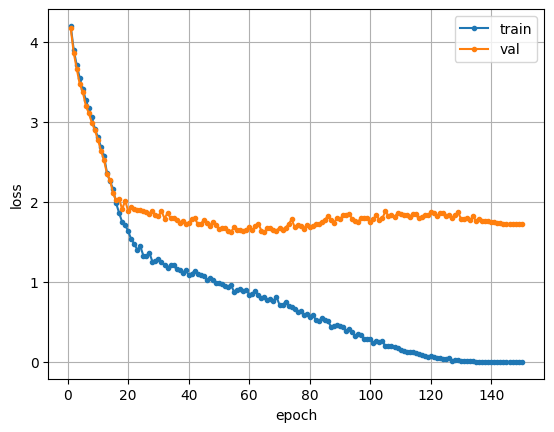

In [24]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['train loss']の長さまでの範囲）
xs = np.arange(1, len(history['train loss']) + 1)
# トレーニングデータの損失をプロット
ax.plot(xs, history['train loss'], '.-', label='train')
# バリデーションデータの損失をプロット
ax.plot(xs, history['val loss'], '.-', label='val')

ax.set_xlabel('epoch') # x軸のラベルを設定
ax.set_ylabel('loss') # y軸のラベルを設定
ax.legend() # 凡例を表示
ax.grid() # グリッドを表示
plt.show() # グラフを表示


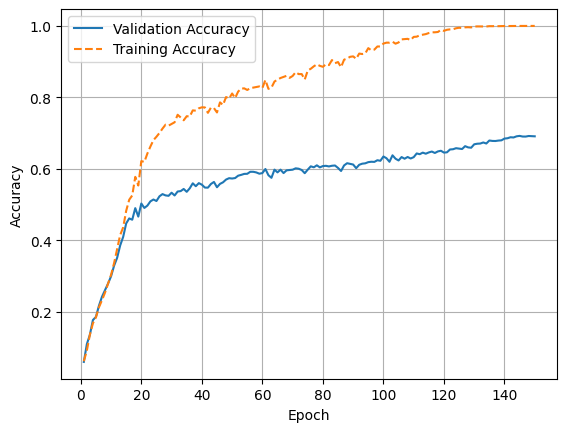

In [25]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['val acc']の長さまでの範囲）
xs = np.arange(1, len(history['val acc']) + 1)
# バリデーションデータの正解率をプロット
ax.plot(xs, history['val acc'], label='Validation Accuracy', linestyle='-')
# トレーニングデータの正解率をプロット
ax.plot(xs, history['train acc'], label='Training Accuracy', linestyle='--')
ax.set_xlabel('Epoch') # x軸のラベルを設定
ax.set_ylabel('Accuracy') # y軸のラベルを設定
ax.grid() # グリッドを表示
ax.legend()  # 凡例を追加
plt.show() # グラフを表示
